# Classifier for Political Ideology using GSS Data

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier

In [36]:

# Political Ideology Classifier Using GSS Data


## Step 2: Load Data
df = pd.read_excel("result-3/GSS.xlsx", sheet_name="Data")

## Step 3: Filter Valid Rows
# Keep only rows where all required values are present
df = df[['year', 'polviews', 'grass', 'abany', 'intenvir']]
df = df.dropna()
df = df[~df.apply(lambda row: row.astype(str).str.contains(":").any(), axis=1)]

## Step 4: Encode Categorical Variables
# Simplify polviews to 3 categories
def simplify_polviews(val):
    if "liberal" in val.lower():
        return "liberal"
    elif "conservative" in val.lower():
        return "conservative"
    elif "moderate" in val.lower():
        return "moderate"
    else:
        return None

df['polviews_simplified'] = df['polviews'].apply(simplify_polviews)
df = df[df['polviews_simplified'].notnull()]
df = df[df['polviews_simplified'] != 'moderate']



# Step 5: Select relevant columns for encoding
selected_cols = ['grass', 'abany', 'intenvir']
df_subset = df[['polviews_simplified'] + selected_cols].copy()


interest_map = {
    "Not at all interested": 0,
    "Moderately interested": 1,
    "Very interested": 2
}

legal_map = {
    "Should be legal" : 1,
    "Should not be legal" : 0
    
}

df['intenvir'] = df['intenvir'].map(interest_map)
df['grass'] = df['grass'].map(legal_map)

df['abany'] = df['abany'].map({"NO": 0, "YES": 1})

df.drop(columns=['year', 'polviews'], inplace=True)


# Now df_encoded is ready for modeling
X = df.drop(columns=['polviews_simplified'])
y = df['polviews_simplified']


## Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.head())


    grass  abany  intenvir
9       1      1         1
16      0      0         2
24      1      1         1
29      1      1         2
52      1      0         2


In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [30]:

#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y)


## Step 7: Train Classifier
model = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=3,         # Let trees grow fully
    random_state=42,
    min_samples_split=2,
    class_weight='balanced')

model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=200,
                       random_state=42)

Mean accuracy: 0.7011627906976744
Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

conservative       0.77      0.77      0.77        26
     liberal       0.67      0.67      0.67        18

    accuracy                           0.73        44
   macro avg       0.72      0.72      0.72        44
weighted avg       0.73      0.73      0.73        44



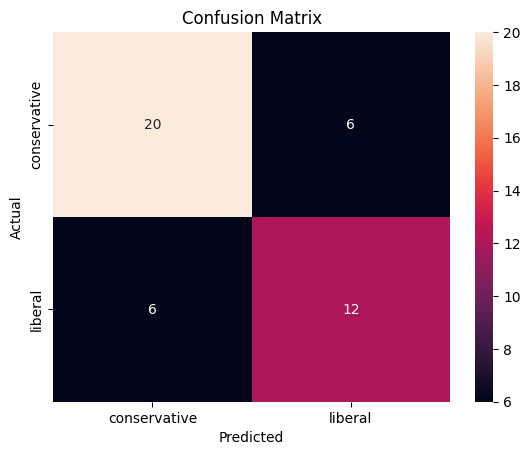

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_importances'

In [31]:
## Step 8: Evaluate
y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=5)
print("Mean accuracy:", scores.mean())

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

## Step 9: Visualize
sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


importances = model.feature_importances
feat_names = X.columns
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances")
plt.show()


# Sentiment analysis on tweets using the model

In [60]:
import pandas as pd

df = pd.read_csv("sm-all.csv", parse_dates=["date"])  # adjust column name if needed
# Add a month column
df['month'] = df['date'].dt.to_period('M')

# Average sentiment per month
monthly_sent = df.groupby('month')[[
    'climatechange_vader_comp_avg',
    'abortion_vader_comp_avg',
    'mj_vader_comp_avg'
]].mean().reset_index()

print(monthly_sent)

      month  climatechange_vader_comp_avg  abortion_vader_comp_avg  \
0   2019-01                     -0.081056                -0.111416   
1   2019-02                     -0.098935                -0.063245   
2   2019-03                     -0.075570                -0.072049   
3   2019-04                     -0.090248                -0.139569   
4   2019-05                     -0.091306                -0.183603   
5   2019-06                     -0.088921                -0.058446   
6   2019-07                     -0.043254                -0.109533   
7   2019-08                     -0.156792                -0.114043   
8   2019-09                     -0.077451                -0.067336   
9   2019-10                     -0.124776                -0.096925   
10  2019-11                     -0.082742                -0.058351   
11  2019-12                     -0.085977                -0.022965   
12  2020-01                     -0.100182                -0.030482   
13  2020-02         

In [61]:
## Mapping sentiment scores to ordinal values 0, 1, 2

def intenvir_to_ordinal(score):
    if score <= -0.001:
        return 0  # Not important
    elif score >= 0.001:
        return 2  # Very important
    else:
        return 1  # Moderately important
def binary_sentiment_to_ordinal(score):
    return 1 if score >= 0 else 0



In [62]:
monthly_sent['intenvir'] = monthly_sent['climatechange_vader_comp_avg'].apply(intenvir_to_ordinal)
monthly_sent['abany'] = monthly_sent['abortion_vader_comp_avg'].apply(binary_sentiment_to_ordinal)
monthly_sent['grass'] = monthly_sent['mj_vader_comp_avg'].apply(binary_sentiment_to_ordinal)


X_sentiment = monthly_sent[['grass', 'abany', 'intenvir']]
monthly_sent['predicted_ideology'] = model.predict(X_sentiment)

print(monthly_sent['predicted_ideology'])

0     conservative
1     conservative
2     conservative
3     conservative
4     conservative
5     conservative
6     conservative
7     conservative
8     conservative
9     conservative
10    conservative
11    conservative
12    conservative
13    conservative
14    conservative
15    conservative
16    conservative
17    conservative
18    conservative
19    conservative
20    conservative
21         liberal
22    conservative
23         liberal
24    conservative
25    conservative
26    conservative
27    conservative
28    conservative
29    conservative
30    conservative
31    conservative
32    conservative
33    conservative
34    conservative
35    conservative
36    conservative
37    conservative
Name: predicted_ideology, dtype: object


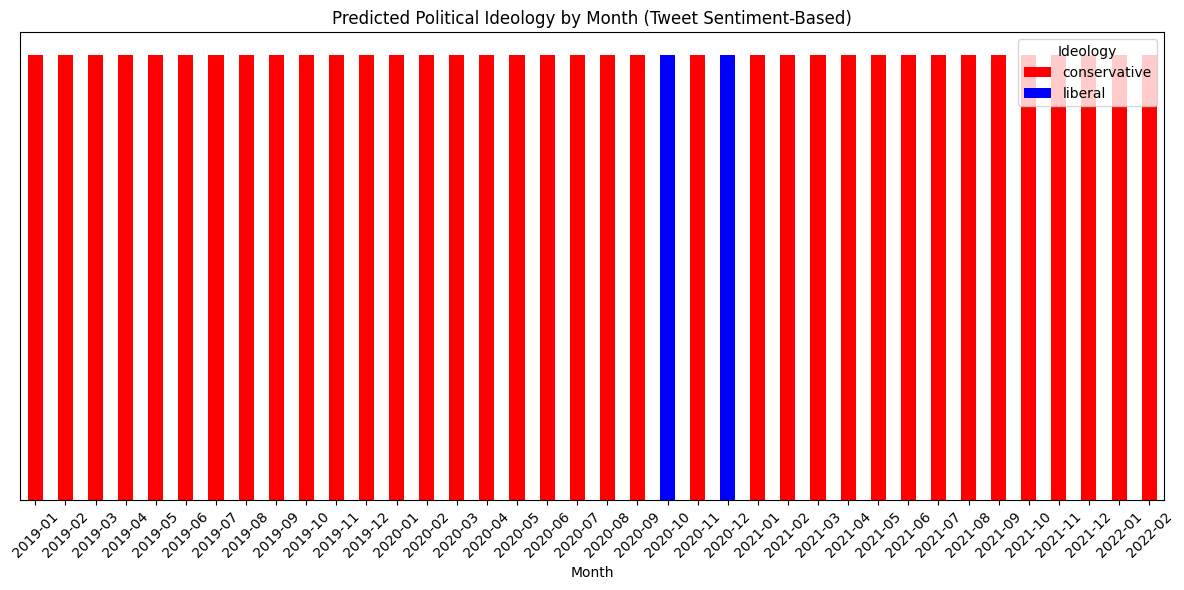

In [67]:
import matplotlib.pyplot as plt

colors = {
    'liberal': 'blue',
    'conservative': 'red'
}

# Ensure month is string for x-axis labeling
monthly_sent['month'] = monthly_sent['month'].astype(str)

# Count ideology predictions per month
ideology_by_month = monthly_sent.groupby(['month', 'predicted_ideology']).size().unstack(fill_value=0)

# Plot
ideology_by_month.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title("Predicted Political Ideology by Month (Tweet Sentiment-Based)")
plt.xlabel("Month")
plt.yticks([])
plt.xticks(rotation=45)
plt.legend(title="Ideology")
plt.tight_layout()
plt.savefig("Monthly_sentiment_analysis.jpg")
plt.show()

